In [1]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive

# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
path1p = os.path.dirname(currentdir)
path2p = os.path.dirname(path1p)
libpath = os.path.join(path1p, "lib")
pwd_mat = os.path.join(os.path.join(path2p, "data/"), "sim_ds_mat")
pwd_h5 = os.path.join(os.path.join(path2p, "data/"), "sim_ds_h5")

sys.path.insert(0, libpath) 
print("Appended library directory", libpath)

# User libraries
from matlab.matlab_yaro_lib import read_mat
from signal_lib import downsample
from corr_lib import sprMat
from idtxl_wrapper import idtxlResults2matrix

# IDTxl libraries
from idtxl.bivariate_mi import BivariateMI
from idtxl.multivariate_mi import MultivariateMI
from idtxl.bivariate_te import BivariateTE
from idtxl.multivariate_te import MultivariateTE
from idtxl.data import Data
from idtxl.visualise_graph import plot_network

Appended library directory /media/aleksejs/DataHDD/work/codes/theoretical-models/experimental-bridge/nest-mesoscopic-metric-test/codes/lib


## 1. Load Neuronal Data

The neuronal data for a given experiment is given by the 3D matrix of dimensions `[N_Trial, N_Times, N_Channels]`

Notes:
* `DT = 0.05` : the sampling interval is always 50ms
* `N_Times = 201` : the total experiment time is always 10s. All experiments are aligned

In [2]:
# Declare constants
params = {
    "folderName" : "mtp_15_2018_05_17_a",
    "folderPath" : "/mnt/hifo_scratch1/Yaro/data_for_TE/mtp/mtp_15",
    
    "exp_timestep" : 0.05, # 50ms, the standard measurement interval
    "bin_timestep" : 0.2,  # 200ms, the binned interval
    
    # The standard timesteps for different scenarios
    "range_CUE" : (1.0, 1.5),    # 1-1.5 seconds trial time
    "range_TEX" : (2.0, 3.5),    # 2-3.5 seconds trial time
    "range_LIK" : (3.5, 6.0),    # 3.5-6 seconds trial time
    "range_ALL" : (0.0, 10.0),   # 0-10  seconds

#     "samples_window" : "ALL",
#     "trials_type"    : "GO",
    "subsampling"    : True,   # To bin or not to bin data
#     "subsampling_windows_lenghts" : 4*np.ones((1,51)),  #uniform subsampling, 50 bins
    
    "te_delay_min" : 1,
    "te_delay_max" : 5,
    
#     "te_delay_stepsize" : 1,
#     "te_receiver_embedding_tau" : 1,
#     "te_sampling_rate" : 20
}

Reading Yaro data from /mnt/hifo_scratch1/Yaro/data_for_TE/mtp/mtp_15/mtp_15_2018_05_17_a
Loaded neuronal data with (nTrials, nTimes, nChannels)= (360, 201, 12)
50
Downsampling from 0.05 ms to 0.2 ms


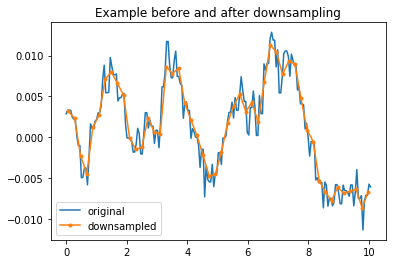

After downsampling data shape is (nTrials, nTimes, nChannels)= (360, 50, 12)


In [3]:
# Read LVM file from command line
data, behaviour = read_mat(os.path.join(params["folderPath"], params["folderName"]))

# Get parameters
nTrials, nTimes, nChannels = data.shape
print("Loaded neuronal data with (nTrials, nTimes, nChannels)=", data.shape)

assert nTimes == 201, "The number of timesteps must be 201 for all data, got "+str(nTimes)
nTimesDownsampled = int(nTimes * params["exp_timestep"] / params["bin_timestep"])
print(nTimesDownsampled)

# Timeline (x-axis)
tlst = params["exp_timestep"] * np.linspace(0, nTimes, nTimes)

# Downsample data
print("Downsampling from", params["exp_timestep"], "ms to", params["bin_timestep"], "ms")
if params["subsampling"]:
    params["timestep"] = params["bin_timestep"]
    tlst_new = downsample(tlst, data[0, :, 0], nTimesDownsampled)[0]
    data_new = np.array([[downsample(tlst, data[i, :, j], nTimesDownsampled)[1] 
                          for i in range(nTrials)] 
                         for j in range(nChannels)])
else:
    params["timestep"] = params["exp_timestep"]
    
# Plot downsampling for comparison
plt.figure()
plt.plot(tlst, data[0, :, 0], label='original')
plt.plot(tlst_new, data_new[0, 0, :], '.-', label='downsampled')
plt.title("Example before and after downsampling")
plt.legend()
plt.show()

# Replace old data with subsampled one    
tlst, data = tlst_new, data_new.transpose(1, 2, 0)
nTrials, nTimes, nChannels = data.shape
print("After downsampling data shape is (nTrials, nTimes, nChannels)=", data.shape)

## Swipe Transfer Entropy via IDTxl

Notation of IDTxl
* `(processes, samples, replications)` equivalent to ours `(channels, times, trials)`
* Thus Yaro matrix `(nTrials, nTimes, nChannels)` is given by `'rsp'`, but
* For example `(nChannels, nTimes)` would be `'ps'`

In [11]:
%%time
net_analysis_lst = [BivariateTE(), MultivariateTE()]
methods_lst = ["BivariateTE", "MultivariateTE"]

settings = {'cmi_estimator': 'JidtGaussianCMI',
            'max_lag_sources': params["te_delay_max"],
            'min_lag_sources': params["te_delay_min"]}

teWindow = params["te_delay_max"] + 1

teSwipeMat_lst = []
lagSwipeMat_lst = []
pSwipeMat_lst = []

for method, na in zip(methods_lst, net_analysis_lst):
    
    teSwipeMat  = np.zeros((nChannels, nChannels, nTimes)) + np.nan
    lagSwipeMat = np.zeros((nChannels, nChannels, nTimes)) + np.nan
    pSwipeMat   = np.zeros((nChannels, nChannels, nTimes)) + np.nan
    
    for i in range(nTimes - teWindow):
        dataIDTxl = Data(data[:, i:i + teWindow, :], dim_order='rsp')
        results = na.analyse_network(settings=settings, data=dataIDTxl)
        te_mat, lag_mat, p_mat = idtxlResults2matrix(results, nChannels, method=method)
        
        teSwipeMat[:,:, i + params["te_delay_max"]]  = te_mat
        lagSwipeMat[:,:, i + params["te_delay_max"]] = lag_mat
        pSwipeMat[:,:, i + params["te_delay_max"]]   = p_mat
        
    teSwipeMat_lst += [teSwipeMat]
    lagSwipeMat_lst += [lagSwipeMat]
    pSwipeMat_lst += [pSwipeMat]

Adding data with properties: 12 processes, 6 samples, 360 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 1) maximum statistic, n_perm: 200
testing candidate: (0, 4) maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200
testing candidate: (0, 5) maximum statistic, n_perm: 200
testing candidate: (0, 3) maximum statistic, n_perm: 200

---------------------------- (2) include source candidates
candidate set current source: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
testing candidate: (1, 5) maximum statistic, n_perm: 200
 -- not significant
candidate set current source: [(2, 1), (2, 2), (2, 3), (2, 4), (2, 5)]
testing candidate: (2, 2) maximum statistic, n_perm: 200
testing candi

testing candidate: (3, 3) maximum statistic, n_perm: 200
testing candidate: (3, 4) maximum statistic, n_perm: 200
testing candidate: (3, 5) maximum statistic, n_perm: 200
testing candidate: (3, 2) maximum statistic, n_perm: 200

---------------------------- (2) include source candidates
candidate set current source: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 3) maximum statistic, n_perm: 200
 -- not significant
candidate set current source: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
testing candidate: (1, 4) maximum statistic, n_perm: 200
 -- not significant
candidate set current source: [(2, 1), (2, 2), (2, 3), (2, 4), (2, 5)]
testing candidate: (2, 2) maximum statistic, n_perm: 200
testing candidate: (2, 5) maximum statistic, n_perm: 200
testing candidate: (2, 3) maximum statistic, n_perm: 200
 -- not significant
candidate set current source: [(4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (4, 3) maximum statistic, n_perm: 200
 -- not significant
candid

testing candidate: (8, 1) maximum statistic, n_perm: 200
 -- not significant
candidate set current source: [(9, 1), (9, 2), (9, 3), (9, 4), (9, 5)]
testing candidate: (9, 1) maximum statistic, n_perm: 200
 -- not significant
candidate set current source: [(10, 1), (10, 2), (10, 3), (10, 4), (10, 5)]
testing candidate: (10, 2) maximum statistic, n_perm: 200
 -- not significant
candidate set current source: [(11, 1), (11, 2), (11, 3), (11, 4), (11, 5)]
testing candidate: (11, 1) maximum statistic, n_perm: 200
testing candidate: (11, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune candidates
selected vars sources [(4, 3), (4, 1), (8, 2), (11, 4)]
selected candidates current source: [(4, 2), (4, 4)]
testing candidate: (4, 4) minimum statistic, n_perm: 500
 -- significant
selected vars sources [(4, 3), (4, 1), (8, 2), (11, 4)]
selected candidates current source: [(8, 3)]
 -- significant
selected vars sources [(4, 3), (4, 1), (8, 2), (11, 4)]
sel

 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 1), (3, 1), (4, 1), (5, 4), (5, 3), (8, 3), (10, 1), (11, 1)]
final target samples: [(7, 4), (7, 1), (7, 3), (7, 2), (7, 5)]



####### analysing target with index 8 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 8 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(8, 1), (8, 2), (8, 3), (8, 4), (8, 5)]
testing candidate: (8, 1) maximum statistic, n_perm: 200
testing candidate: (8, 2) maximum statistic, n_perm: 200
testing candidate: (8, 4) maximum statistic, n_perm: 200
testing candidate: (8, 5) maximum statistic, n_perm: 200
testing candidate: (8, 3) maximum statistic, n_perm: 200

---------------------------- (2) include source candidates
candidate set current source: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 1) maximum statistic, n_perm: 200
 -- not significant
candidate set current sou

 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(4, 3)]
final target samples: [(10, 1), (10, 2), (10, 4), (10, 5), (10, 3)]



####### analysing target with index 11 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 11 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

---------------------------- (1) include target candidates
candidate set: [(11, 1), (11, 2), (11, 3), (11, 4), (11, 5)]
testing candidate: (11, 1) maximum statistic, n_perm: 200
testing candidate: (11, 3) maximum statistic, n_perm: 200
testing candidate: (11, 4) maximum statistic, n_perm: 200
testing candidate: (11, 2) maximum statistic, n_perm: 200
testing candidate: (11, 5) maximum statistic, n_perm: 200

---------------------------- (2) include source candidates
candidate set current source: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 3) maximum statistic, n_perm: 200
 -- not significant
candidate set current source: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 

testing candidate: (3, 3) maximum statistic, n_perm: 200
testing candidate: (3, 4) maximum statistic, n_perm: 200
testing candidate: (3, 5) maximum statistic, n_perm: 200
testing candidate: (3, 2) maximum statistic, n_perm: 200

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5)]
testing candidate: (5, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
no sources selected, nothing to prune ...

---------------------------- (4) final statistics
no sources selected

 -- not significant

---------------------------- (3) prune source candidate
no sources selected, nothing to prune ...

---------------------------- (4) final statistics
no sources selected ...
final source samples: []
final target samples: [(8, 1), (8, 2), (8, 4), (8, 5), (8, 3)]



####### analysing target with index 9 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 9 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(9, 1), (9, 2), (9, 3), (9, 4), (9, 5)]
testing candidate: (9, 1) maximum statistic, n_perm: 200
testing candidate: (9, 3) maximum statistic, n_perm: 200
testing candidate: (9, 4) maximum statistic, n_perm: 200
testing candidate: (9, 2) maximum statistic, n_perm: 200
testing candidate: (9, 5) maximum statistic, n_perm: 200

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1)

In [13]:
import h5py

#######################
# Save results to file
#######################
for i, method in enumerate(methods_lst):
    savename = os.path.join(pwd_h5, params["folderName"] + '_' + method + '.h5')
    
    h5f = h5py.File(savename, "w")
    
    grp_rez = h5f.create_group("results")
    grp_rez['TE_table'] = teSwipeMat_lst[i]
    grp_rez['delay_table'] = lagSwipeMat_lst[i]
    grp_rez['p_table'] = pSwipeMat_lst[i]
    
    h5f.close()